#### Case 2: Liquid hydrogen ($LH_2$) in a 2033 $\text{m}^3$ tank

This application corresponds to liquid hydrogen storage in the NASA's Space Launch System. It consists of a 2033 $m^3$ storage tank [NASA](https://www.energy.gov/sites/default/files/2021-10/new-lh2-sphere.pdf) in a tank with 8.4 m diameter and 40 m height. It will be assumed the following operation scenarios:

* Daily boil-off rate of 0.1%  
* Storage at atmospheric pressure with continuous removal of boil-off gas

For purposes of the example, it is assumed that the storage tank is passively insulated with perlite.

In [1]:
# Scientific computing
import numpy as np

# Visualisation
import matplotlib.pyplot as plt

# Import the storage tank Class
from cryoevap.storage_tanks import Tank

# Import Cryogen class
from cryoevap.cryogens import Cryogen

#### Setup tank and cryogen properties


In [2]:
# Cylindrical storage tank properties
Q_roof = 0 # Roof heat ingress / W
d_i = 8 # Internal diameter / m
d_o = 8.4   # External diameter / m
T_air = 293.15 # Temperature of the environment K

# Set overall heat transfer coefficient through the walls for liquid and vapour
U_L = 3.73e-3 # W/m2/K
U_V = 3.73e-3 # W/m2/K

# Specify heat transfer rate at the bottom
# This will represent the heat conduction from the piping system
Q_b = 100 # W, 

# Vertically orientated cylindrical tank volume
V_tank = 2033 #m^3

# Initial liquid filling / Dimensionless
LF = 0.50 

# Specify tank operating pressure
P = 101325 # Pa

# Initialize mid-scale tank
mid_tank = Tank(d_i, d_o, V_tank, LF)
mid_tank.set_HeatTransProps(U_L, U_V, T_air, Q_b, Q_roof, eta_w= 0.8)

# Keep the tank roof insulated
mid_tank.U_roof = 0

# Initialise cryogen
hydrogen = Cryogen(name = "hydrogen")
hydrogen.set_coolprops(P)

# Set cryogen
mid_tank.cryogen = hydrogen

Calculate initial evaporation rate and transient period

In [3]:
# Calculate initial evaporation rate
print("The initial evaporation rate of " + hydrogen.name + " is %.1f kg/h" % (mid_tank.b_l_dot * 3600))

# Estimate transient period duration
print("Transient period = %.3f s " % mid_tank.tau)

# Minimum number of hours to achieve steady state 
tau_h = (np.floor(mid_tank.tau / 3600) + 1)

# Print simulation time of the transient period for short-term storage
print("Simulation time: %.0i h" % tau_h )

# Calculate boil-off rate
BOR = (mid_tank.b_l_dot * 24 * 3600) / (mid_tank.V * mid_tank.LF * mid_tank.cryogen.rho_L)
print("BOR = %.3f %%" % (BOR * 100))

The initial evaporation rate of hydrogen is 8.6 kg/h
Transient period = 1127967.052 s 
Simulation time: 314 h
BOR = 0.288 %


### Simulation setup and execution

In [4]:
# Define vertical spacing
dz = 0.1

# Calculate number of nodes
n_z = 1 + int(np.round(mid_tank.l_V/dz, 0))

# Define dimensionless computational grid
mid_tank.z_grid = np.linspace(0, 1, n_z)

# Define evaporation time as the transient period
evap_time = 3600 * tau_h

# Time step to plot each vapour temperature profile
mid_tank.plot_interval = evap_time/6

# Time step to record data, relevant for plotting integrated quantities such as
# the vapour to liquid heat transfer rate, Q_VL
mid_tank.time_interval = 60

mid_tank.evaporate(evap_time)

### Visualisation of results

#### Vapour temperature

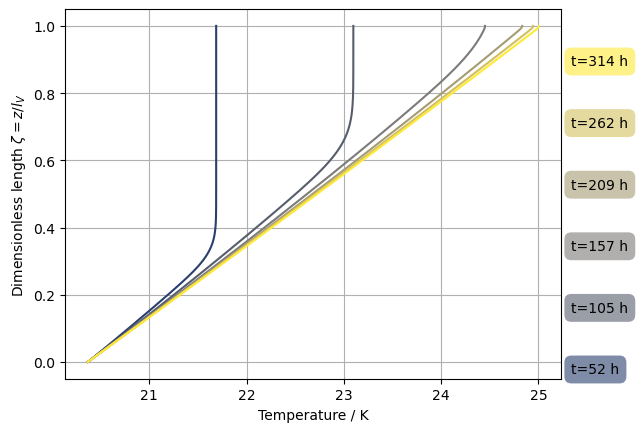

In [5]:
mid_tank.plot_tv(t_unit='h')

Visualise liquid and vapour heat ingresses, $\dot{Q}_{\text{L}}$ and  $\dot{Q}_{\text{V}}$.

The plot also shows the vapour to liquid heat ingress, $\dot{Q}_{VL}$, and  the partition of the vapour heat ingress that is transferred to the interface by the wall directly, $\dot{Q}_{\text{V,w}}$

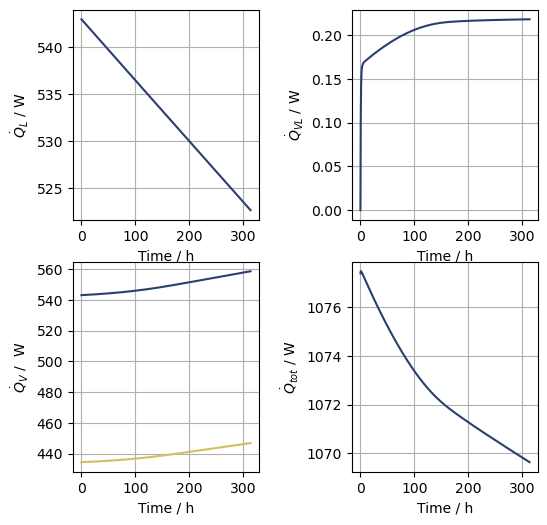

In [6]:
# Specify y-axis units as W, and time units to hours
mid_tank.plot_Q(unit = 'W', t_unit = 'h')

#### Plot liquid volume

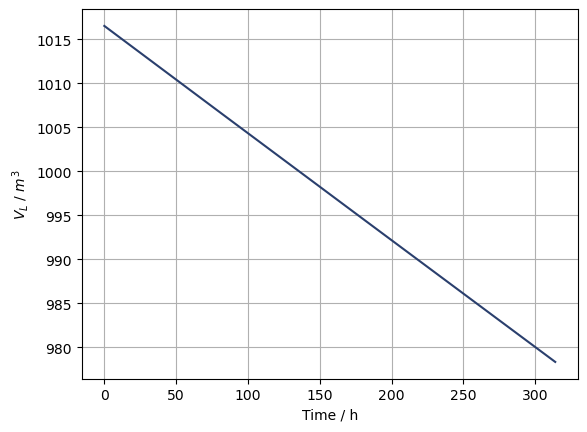

In [7]:
mid_tank.plot_V_L(t_unit='h')

#### Plot evaporation rate, $\dot{B}_{\text{L}}$, and boil-off gas rate, $\dot{B}_{}$

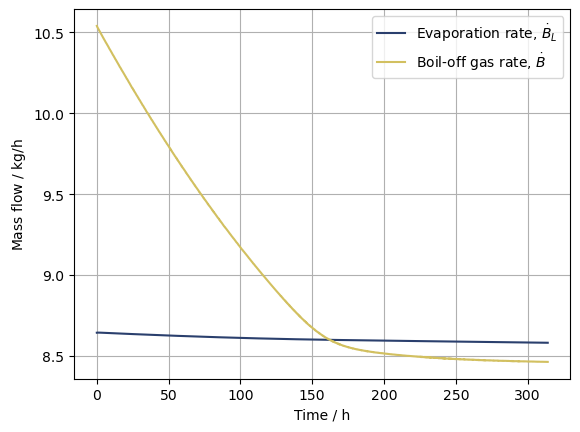

In [8]:
mid_tank.plot_BOG(unit='kg/h', t_unit='h')

Optional: CSV data export

If evaporation data is intended to be post-processed in another software, it can be exported readily with the help of the Pandas package.

In [9]:
# Import pandas 
import pandas as pd

In [10]:
# Create dataframe from dictionary
df_evap = pd.DataFrame.from_dict(mid_tank.data)

# Save file to the current working directory
df_evap.to_csv('iso_LH2_2033m3.csv')

# Show the first five columns of the dataframe in console
df_evap.head()

,Time,Tv_avg,rho_V_avg,Q_VL,Q_L,Q_V,V_L,B_L,BOG,drho_V_avg,dV_L,T_BOG,Q_Vw,Q_tot
0,0.0,20.368904,1.332170,0.000000,542.987446,542.987446,1016.500000,0.002401,0.002401,0.000000e+00,0.000000,20.368904,434.389957,1077.377403
1,60.0,20.369303,1.332136,0.005160,542.986360,542.987738,1016.497967,0.002401,0.002928,-5.623758e-07,-0.000034,20.369303,434.390190,1077.381710
2,120.0,20.369702,1.332103,0.010133,542.985274,542.988030,1016.495933,0.002401,0.002928,-5.623194e-07,-0.000034,20.369703,434.390424,1077.385831
3,180.0,20.370101,1.332069,0.014929,542.984188,542.988322,1016.493900,0.002401,0.002927,-5.622074e-07,-0.000034,20.370103,434.390658,1077.389774
4,240.0,20.370500,1.332035,0.019554,542.983101,542.988614,1016.491866,0.002401,0.002927,-5.620972e-07,-0.000034,20.370503,434.390891,1077.393547


Plot average vapour and boil-off gas temperature

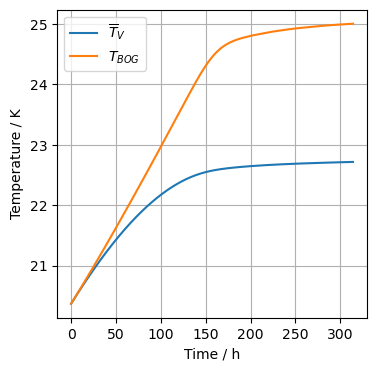

In [11]:
mid_tank.plot_tv_BOG(t_unit='h')

#### References

U.S. Department of Energy. (2021, October). DOE/NASA Advances in Liquid Hydrogen Storage Workshop. Retrieved from [https://www.energy.gov/sites/default/files/2021-10/new-lh2-sphere.pdf]